# Code for competition

In [28]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the dataset

In [29]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]
for i in range(0, len(images_ind)):
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

(3542, 96, 96, 3) (3542, 8)
uint8, uint8


### Models metadata

In [30]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]
batch_size = 128
epochs = 200
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

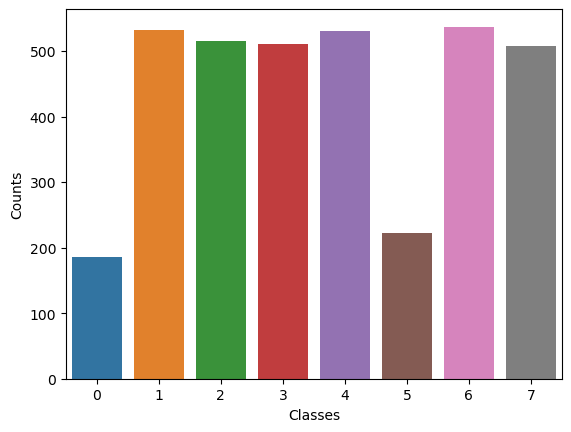

In [31]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [32]:
shift_range = 20
gen = ImageDataGenerator(rotation_range=90,  #TODO: choose the transformations
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         horizontal_flip=True,
                         vertical_flip=True,
                         zoom_range = 0.3,
                         fill_mode='reflect')

desired_amount = 700

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(labels)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

# Apply augmentation
for i in range(0, len(labels)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(labels))
    print(f'Computing {to_produce} augmented images for target {i}')
    aug_targets_i = np.full((length, len(labels)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

# augmented dataset
X_aug = np.concatenate((X, np.array(aug_samples, dtype=np.uint8)))
y_aug = np.concatenate((y, np.array(aug_targets, dtype=np.uint8)))
print(X_aug.shape, X_aug.dtype, sep=", ")
print(y_aug.shape, y_aug.dtype, sep=", ")

Computing 514 augmented images for target 0
Computing 168 augmented images for target 1
Computing 185 augmented images for target 2
Computing 189 augmented images for target 3
Computing 169 augmented images for target 4
Computing 478 augmented images for target 5
Computing 163 augmented images for target 6
Computing 192 augmented images for target 7
(5600, 96, 96, 3), uint8
(5600, 8), uint8


### Test pre-processing

In [33]:
# Saturation adjustment
new_aug_samples = []
for img in aug_samples: 
    new_aug_samples.append(np.array(tf.image.adjust_saturation(img, 2.5)))

### Show some example of augmented images

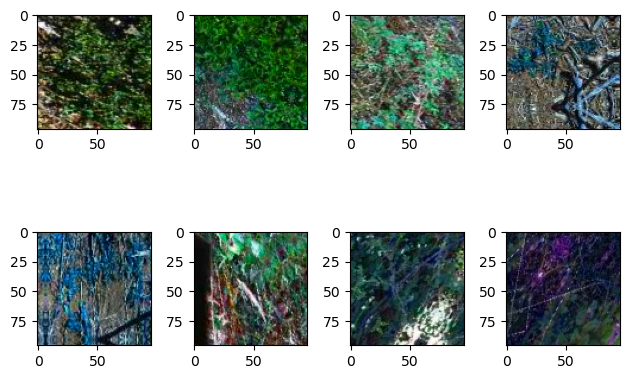

In [34]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):

    img = random.choice(new_aug_samples)  # chaneg to new_aug_samples to see preprocessing effects
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.fromarray(img.astype(np.uint8)))

plt.tight_layout()
plt.show()

### Apply pre-processing
All that is done here must be included in the pre-processing phase

In [35]:
# Contrast-Saturation adjustment
temp = []
for img in X_aug: 
    temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 2.5), 1.05)))

X_aug = np.array(temp)
print(X_aug.shape, X_aug.dtype, sep=", ")


(5600, 96, 96, 3), uint8


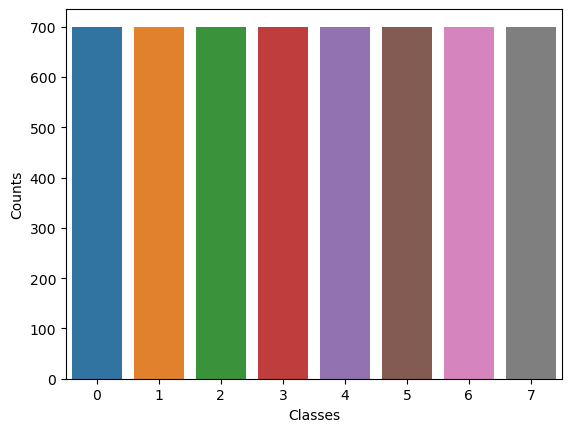

In [36]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Split training-validation

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, X_train.dtype, y_train.shape, y_train.dtype, sep=", ")
print(X_val.shape, X_val.dtype, y_val.shape, y_val.dtype, sep=", ")

(4760, 96, 96, 3), uint8, (4760, 8), uint8
(840, 96, 96, 3), uint8, (840, 8), uint8


### Models definition functions

In [38]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.VGG19(include_top=False,
                                      weights="imagenet",
                                      input_shape=input_shape)

    # Use the supernet as feature extractor
    supernet.trainable = False
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout3')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout4')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='dropout5')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [39]:
model = build_tl_model(input_shape)

# Apply fine tuning
model.get_layer('vgg19').trainable = True
for i, layer in enumerate(model.get_layer('vgg19').layers[:-1]):
  layer.trainable=False

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 dense1 (Dense)              (None, 512)               262656    
                                                                 
 dropout1 (Dropout)          (None, 512)               0         
                                                                 
 dense2 (Dense)              (None, 256)               131328    
                                                          

### Train the model

In [40]:
# Transfer learning preprocessing (to be included in the preprocessing)
#from tensorflow.keras.applications.vgg16 import preprocess_input
#X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
#X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
38/38 [==============================] - 26s 646ms/step - loss: 6.4844 - accuracy: 0.1458 - val_loss: 2.0077 - val_accuracy: 0.2440
Epoch 2/200
38/38 [==============================] - 26s 678ms/step - loss: 2.2557 - accuracy: 0.1660 - val_loss: 2.0369 - val_accuracy: 0.2345
Epoch 3/200
38/38 [==============================] - 26s 680ms/step - loss: 2.1144 - accuracy: 0.1731 - val_loss: 1.9772 - val_accuracy: 0.2786
Epoch 4/200
38/38 [==============================] - 26s 698ms/step - loss: 2.0183 - accuracy: 0.2040 - val_loss: 1.8705 - val_accuracy: 0.3310
Epoch 5/200
38/38 [==============================] - 27s 723ms/step - loss: 1.9303 - accuracy: 0.2462 - val_loss: 1.7818 - val_accuracy: 0.3702
Epoch 6/200
38/38 [==============================] - 28s 739ms/step - loss: 1.8553 - accuracy: 0.2672 - val_loss: 1.6898 - val_accuracy: 0.3869
Epoch 7/200
38/38 [==============================] - 29s 755ms/step - loss: 1.7999 - accuracy: 0.2954 - val_loss: 1.6414 - val_accuracy:

KeyboardInterrupt: 

### Plot training results

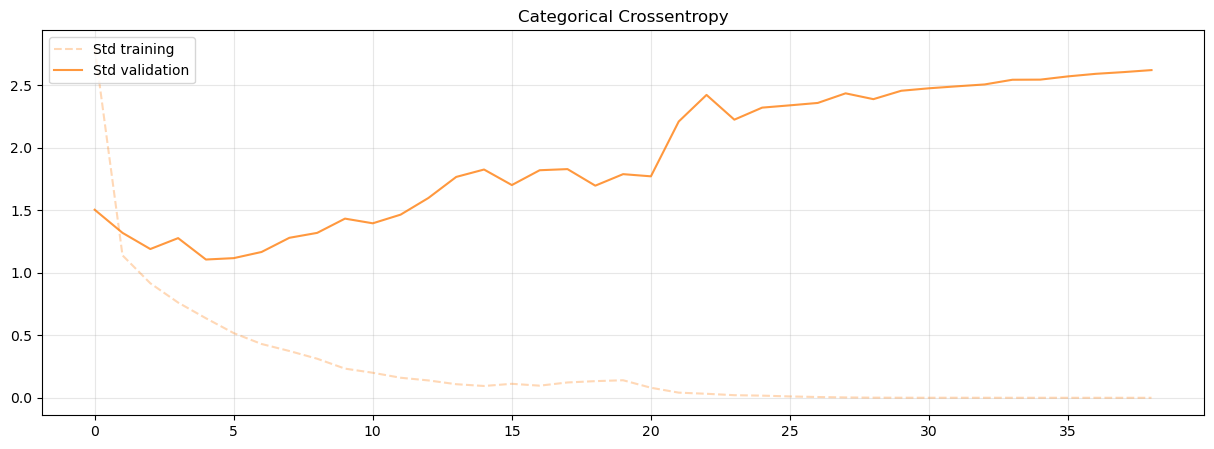

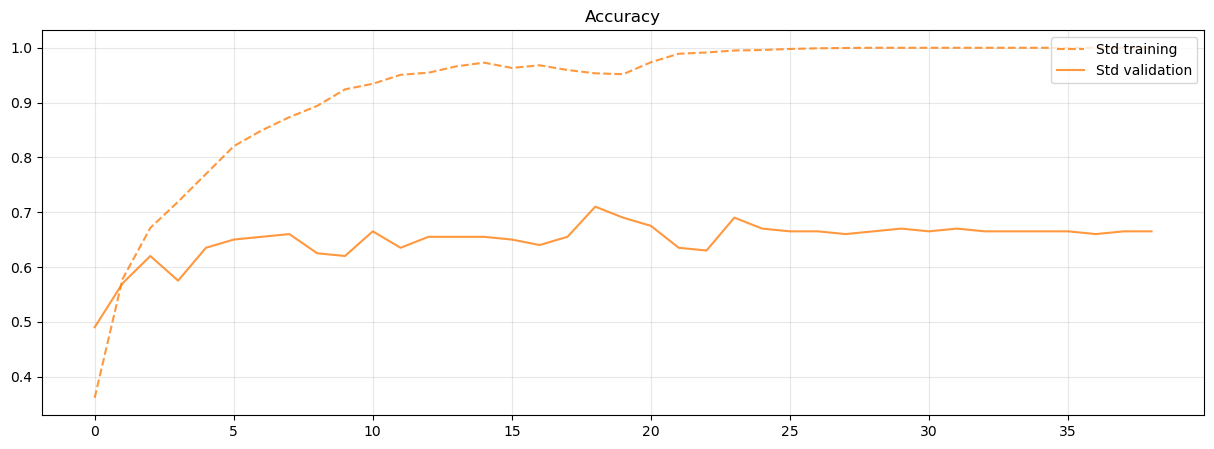

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

7/7 [==============================] - 11s 567ms/step
Accuracy: 0.71
Precision: 0.7342
Recall: 0.71
F1: [0.5    0.6429 0.7826 0.7347 0.7692 0.6341 0.8333 0.7   ]


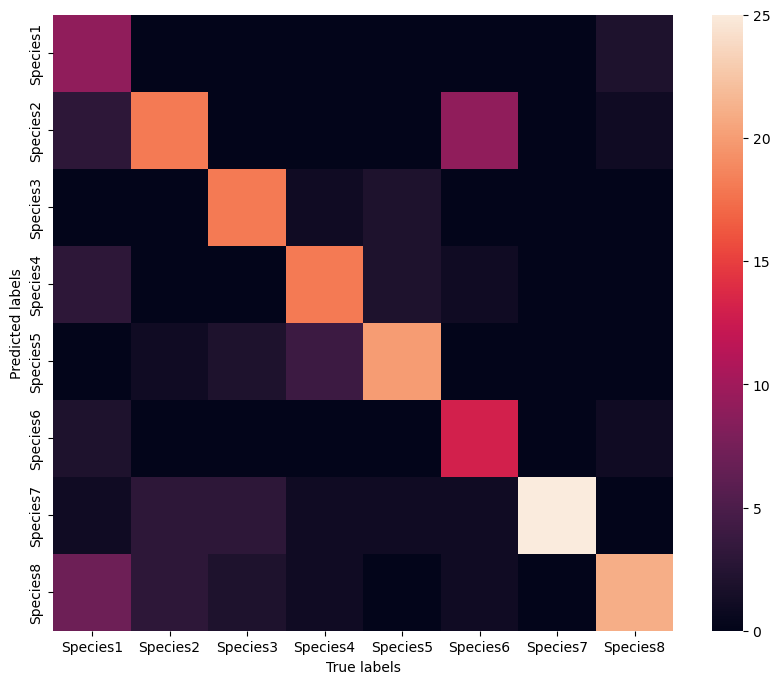

In [ ]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [ ]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

7/7 - 2s - loss: 0.2509 - accuracy: 0.9050 - 2s/epoch - 253ms/step
7/7 - 1s - loss: 1.6978 - accuracy: 0.7100 - 1s/epoch - 169ms/step
No improvement!
